# 2. 实现新的 Planner

你可以参考 [Partnr Doc - Adding a new planner](https://github.com/RoboticSJTU/partnr-planner/blob/main/docs/tutorials/adding_new_planners.md) 来了解如何实现一个新的 Planner。

本文档以 [embodiment_planners/planner.py](./embodiment_planners/planner.py) 中实现的简单 LLM Planner ，和 [python_package/embodiment/dummy_planner.py](./python_package/embodiment/dummy_planner.py) 中实现的虚拟 Planner 为例，介绍 Planner 实现方式，以及其核心接口。

## 2.1 Planner Interface

`habitat_llm_planner.Planner` 是所有 Planner 所共同继承的基类，其定义了 Planner 所具有的接口。要继承该基类实现新的 Planner，你需要至少实现以下两个接口

```python
def get_next_action(
        self,
        instruction: str,
        observations: Dict[str, Any],
        world_graph: Dict[int, "WorldGraph"],
    ) -> Tuple[Dict[int, Any], Dict[str, Any], bool]:
        """
        Gives the next low level action to execute.

        :param instruction: The instruction for the task.
        :param observations: The current observations.
        :param world_graph: The world graph for each agent.
        :return: A tuple containing:
                 - The low-level actions for each agent
                 - Planner information
                 - Whether the planner is done
        """
    ...

def reset(self) -> None:
        """
        Reset the planner state.
        """
    ...
```

对于每个 Episode，`EvaluationRunner` 会按照以下逻辑进行 Planning 和 Execution

- 从 Episode 读取场景状态，初始化仿真环境和 world graph
- 从 Episode 读取 instruction
- 从仿真环境读取 observation，其内容为各个 sensor 的 output，例如机器人所看到的 rgb/depth/semantic 图像。
- 从仿真环境读取 world graph，我们会在 tutorial 3 中详细介绍 world graph
- 使用上述信息，调用 `planner.get_next_action`
- 如果 超出步数限制/超出时间限制/Planner返回`is_done=True`，则调用 `planner.reset()` 并继续处理下一个 Episode

<span style="color:red">**在 Planner 实现中，你只能通过 get_next_action 的参数 observations 和 world_graph 来获取场景信息，只能通过 get_next_action 的返回值来影响环境状态。**</span>

## 2.2 get_next_action

### 2.2.1 observations 参数

`get_next_action` 的第一个参数 `observations` 是仿真环境中的 sensor 的输出，需要注意的是这些 sensor 不仅仅包含常见的图像传感器，也包含一些诸如夹爪状态、机械臂姿态等信息。在本项目中，机器人的机械臂是固定的，并且 world graph 会提供大多数的语义级别信息，**理论上可以完全不使用 Observation，只使用 world graph 完成规划算法**。

另外，`EnvironmentInterface` 对 observation 进行了额外的封装，observation 类型为 `Dict[str, torch.Tensor]`，其 key 为 sensor_name，value 均为 torch tensor，并且其第一个维度为 batch dim，且在本题目的环境设置中 `batch_size=1`。

### 2.2.2 world graph 参数

World Graph 是整个场景语义信息的描述，其节点（也称为 Entity）为场景中的不同元素，可以是房间、家具、摆放区域、物品、或机器人。边则代表从属关系，实际语义由该边所连接的节点类型决定。

Entity Types
- Room: 房间
- Furniture: 家具
- Receptacle: 摆放区域，一个家具可以有多个摆放区域
- Object: 物体，通常代表可以被机器人抓取、摆放的物体。
- SpotRobot: 机器人，有移动能力和抓取、摆放能力
- Human: 人类，由于本项目不牵扯到人机协作，大部分情况下该节点可以忽略。

Edge Types
- Room - SpotRobot: 代表机器人处于某个房间
- Room - Furniture - Receptacle: 场景的拓扑关系
- Receptacle - Object: 物品的摆放位置
- SpotRobot - Object: 机器人正抓取着某个物品

在 tutorial 03 中会详细介绍 WorldGraph 相关接口。

另外，`Planner.get_next_action` 参数中的 WorldGraph 并不是完整 WorldGraph，而是机器人当前已经获取过的信息所组成的 partial WorldGraph。

partial WorldGraph 的更新逻辑是

- 初始情况下不包含任何 Object Entity
- 随着机器人的移动，WorldGraph 会随着机器人的 observation 更新。
- 已经加入的物品不会被删除。

在 [python_package/embodiment/dummy_planner.py](./python_package/embodiment/dummy_planner.py) 中实现的 DummyPlanner 可以很直观的演示 WorldGraph 的更新逻辑，该 Planner 不会进行规划，而是执行当前设定的 high level action，并将 world graph 中的物品直接以文字形式显示在图片上。

high level action 详见 [2.2.3](#223-return-values) 章节

In [1]:
from omegaconf.dictconfig import DictConfig
from embodiment.dummy_planner import DummyPlanner

from python_package.embodiment.runner import PartnerRunner
from hydra import initialize, compose

initialize(config_path="conf")
# 通过 overrides 来覆盖配置文件中的参数
config = compose(config_name="example_simple_planner.yaml",
                 overrides=["evaluation.agents.agent_0.planner._target_=embodiment.dummy_planner.DummyPlanner",
                     "evaluation.output_dir=outputs", "paths.results_dir=outputs"])

runner = PartnerRunner(config)
planner: DummyPlanner = runner.planner[0]
planner

/tmp/ipykernel_4058456/867592427.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="conf")
/home/yongxi/App/anaconda3/envs/habitat-llm/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'example_simple_planner.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
2025-05-22 20:26:47,481 initializing sim CollaborationSim-v0


Finished setting up config


2025-05-22 20:26:50,579 Initializing task RearrangeEmptyTask-v0
MeshTools::compile(): ignoring unknown/unsupported attribute Trade::MeshAttribute::Custom(0)
MeshTools::compile(): ignoring unknown/unsupported attribute Trade::MeshAttribute::Custom(1)


successfully added agent with UID : 0
finished initializing agents!


In [2]:
# 编写可视化代码来实时从 notebook cell 中显示图像
from embodiment.dummy_planner import display_image_in_cell
import queue
import threading
import time

q = queue.Queue()

def vis_thread():
    while True:
        item = q.get()
        if item is None:
            continue
        display_image_in_cell(item)
        # 如果需要在每次显示图像后暂停一段时间，可以使用 time.sleep()
        
planner.set_image_queue(q)
thread = threading.Thread(target=vis_thread)
thread.start()

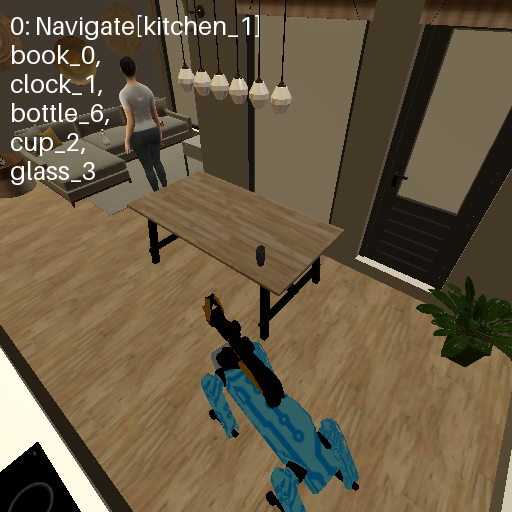

{'task_percent_complete': 0.0,
 'task_state_success': 0.0,
 'total_step_count': 195,
 'runtime': 15.580889225006104,
 'image_text': '0: Navigate[kitchen_1]\nbook_0,\nclock_1,\nbottle_6,\ncup_2,\nglass_3',
 'stats': {'task_percent_complete': 0.0, 'task_state_success': 0.0},
 'sim_step_count': 195,
 'curr_graph': {0: 'Furniture:\nporch_1: floor_porch_1\nporch_2: floor_porch_2\nbathroom_1: floor_bathroom_1\nbathroom_2: floor_bathroom_2, washer_dryer_10\nbedroom_1: floor_bedroom_1, shelves_12, shelves_14, stool_15, bed_17\nbedroom_2: floor_bedroom_2, table_13, bed_19, stand_23\nentryway_1: floor_entryway_1\nworkout_1: floor_workout_1\nliving_room_1: floor_living_room_1, table_11, couch_18, table_20, fridge_22\nkitchen_1: floor_kitchen_1, table_16, cabinet_21\n\nObjects:\nbook_0: table_11\nclock_1: table_11\nbottle_6: couch_18\ncup_2: couch_18\nglass_3: table_16\n'}}

In [3]:
runner.reset(episode_id='919')
planner.action = {0: ('Navigate', 'kitchen_1', None)}
runner.run_instruction("dummy", "dummy")

除了 dummy_planner 中使用的可视化方式，habitat simulator 还提供了 [DebugVisualizer](https://github.com/facebookresearch/habitat-lab/blob/main/habitat-lab/habitat/sims/habitat_simulator/debug_visualizer.py) 等可视化工具，在本项目文档中不会介绍这些工具的使用方式，如果你需要更好的可视化来调试 Planner，你可以自行尝试。

### 2.2.3 Return Values

`Planner.get_next_action` 的返回值有三部分
- `low_leval_actions: Dict[int, NDArray]`: `Planner.process_high_level_actions` 返回的 low level action，key 恒为 `0`，value 为 1D Array。
- `planner_info: Dict[str, Any]`: 一些用于 log 输出的信息，可以忽略，直接返回 `{}` 即可。以下特殊字段会在 evaluation 测评阶段产生影响
    - `high_level_actions`: 如果该字段存在，测评脚本会将其中的 high level action 信息以文字形式添加到输出的视频中。注意该字段 value 必须是合法的 high level action，否则可能导致测评脚本报错。
    - `image_text`: 如果该字段存在，测评脚本会将其中的文字一并添加到输出的视频中。
- `is_done: bool`: 当前规划是否完成。

返回值的第一部分 `low_leval_actions` 可以由 `Planner.process_high_level_actions` 得到，该函数将语义级别的 high level action 处理成仿真器可以直接执行的 low level action，该工具函数使得规划算法可以只关心如何规划语义级别的 high level action，例如前往特定房间，而不用关心动作具体的执行，例如移动的方向。

```python
def process_high_level_actions(
        self, hl_actions: Dict[int, Tuple[str, str, str]], observations: Dict[str, Any]
    ) -> Tuple[Dict[int, Any], Dict[int, str]]:
        """
        Process high-level actions and generate low-level actions and responses.

        :param hl_actions: A dictionary of high-level actions for each agent.
        :param observations: The current observations.
        :return: A tuple containing:
                 - A dictionary of low-level actions for each agent
                 - A dictionary of responses for each agent
        """
    ...
```

一个完整的 high level action 格式如下

```python
{
    agent_id: # 恒为 0
        (action_name, action_input, error_message)
}
```

当前环境支持的所有 high level action 如下


In [4]:
print(runner.hl_action_descriptions)

- Clean: Used for cleaning an object. You need to provide the name of the object to clean.
- Close: Used for closing an articulated entity. You must provide the name of the furniture you want to close. Example (Close[chest_of_drawers_1])
- Explore: Search a specific room by visiting various receptacles or furnitures in that room. The input to the skill is the EXACT name of the room to be visited. Use the room names provided in the house description. This tool exhaustivly explores the specified room. Example (Explore[kitchen_1])
- Fill: Used for filling an object. You need to provide the name of the object to fill.
- Navigate: Used for navigating to an entity. You must provide the name of the entity you want to navigate to. Example (Navigate[counter_22])
- Open: Used for opening an articulated entity. You must provide the name of the furniture you want to open. Example (Open[chest_of_drawers_1])
- Pick: Used for picking up an object. You must provide the name of the object to be picked.

action_input 根据不同的 action 有所不同，在大多数情况下都由 world graph 中的 entity name 和分隔符 `,` 构成。

需要特别说明的是 `Place` action 的 action_input 格式，其格式为

`<object>,<spatial_relation>,<furniture>,<spatial_constraint>,<obj_or_furniture>`
- `object`: 放置的物品节点名称
- `spatial_relation`: `on` 或者 `within`
- `furniture`: 目标家具的节点名称
- `spatial_constraint`: `next_to` 或者 `None`，代表摆放位置是否相邻某个物品或家具
- `obj_or_furniture`: 相邻的物品或家具的节点名称，或者为 `None`

例如

```python
{0: ('Place', 'kettle_1,on,table_1,next_to,apple', None)}
{0: ('Place', 'kettle_1,within,drawer_1,None,None', None)}
```

**process_high_level_actions 返回值1：low level action**

可以直接作为 `Planner.get_next_action` 返回值中的一部分，且可以直接作为 `EnvironmentInterface.step` 的参数一部分。

**process_high_level_actions 返回值2：responses**

以下三种情况，`Planner.process_high_level_actions` 所返回的 responses 各不相同

- high level action 可以执行，且执行当前 low level action 后未完成，此时 responses 为 

In [5]:
response_not_complete = planner.process_high_level_actions(hl_actions={0: ('Navigate', 'bedroom_1', None)}, observations={})[1]
response_not_complete

{0: ''}

- high level action 可以执行，且执行当前 low level action 后该 high level action 即完成，此时 responses 为

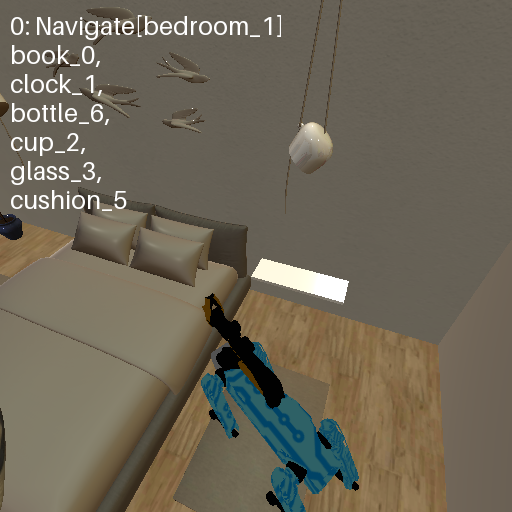

{'task_percent_complete': 0.0,
 'task_state_success': 0.0,
 'total_step_count': 205,
 'runtime': 16.796409368515015,
 'image_text': '0: Navigate[bedroom_1]\nbook_0,\nclock_1,\nbottle_6,\ncup_2,\nglass_3,\ncushion_5',
 'stats': {'task_percent_complete': 0.0, 'task_state_success': 0.0},
 'sim_step_count': 205,
 'curr_graph': {0: 'Furniture:\nporch_1: floor_porch_1\nporch_2: floor_porch_2\nbathroom_1: floor_bathroom_1\nbathroom_2: floor_bathroom_2, washer_dryer_10\nbedroom_1: floor_bedroom_1, shelves_12, shelves_14, stool_15, bed_17\nbedroom_2: floor_bedroom_2, table_13, bed_19, stand_23\nentryway_1: floor_entryway_1\nworkout_1: floor_workout_1\nliving_room_1: floor_living_room_1, table_11, couch_18, table_20, fridge_22\nkitchen_1: floor_kitchen_1, table_16, cabinet_21\n\nObjects:\nbook_0: table_11\nclock_1: table_11\nbottle_6: couch_18\ncup_2: couch_18\nglass_3: table_16\ncushion_5: bed_17\n'}}

In [6]:
planner.action = {0: ('Navigate', 'bedroom_1', None)}
runner.run_instruction("dummy", "dummy")

In [7]:
# last_response 缓存了任务完成前最后一个 response
planner.last_response

{0: 'Successful execution!'}

- high level action 不可以执行，此时 responses 中会包含失败原因

In [8]:
low_level_action, response_fail = planner.process_high_level_actions({0: ('Navigate', 'no_such_room', None)}, {})
response_fail

{0: 'Node with name no_such_room not present in the graph. Use the appropriate tool to get a valid name.'}

### 2.2.4 总结

要实现一个 Planner，你需要在 `Planner.get_next_action` 接口中，根据传入的 world graph 以及 observation，通过规划决定接下来应当采取的 high level action，并通过 `Planner.process_high_level_actions` 来获取实际应当返回的 low level action。

另外，由于单个 high level action 的执行可能需要多步 low level action，你需要根据 `Planner.process_high_level_actions` 所返回的 responses 来决定当前的 low level action 是否是最后一个 low level action，并决定在下一次 `get_next_action` 被调用时，下一个要执行的 high level action 是什么。

## 2.3 调用 LLM 进行规划

如果要实现基于 LLM 的 Planner，你可以直接继承基类 `LLMPlanner`，该类对 prompt 构建、high level action 解析、LLM调用等功能进行了实现和封装。

在 [embodiment_planners/planner.py](./embodiment_planners/planner.py) 中实现的 `EmbodimentPlanner` 直接继承自 `LLMPlanner`，你可以在该 Planner 的基础上进一步优化以实现你自己的 LLM Based Planner。示例 Planner 的实现逻辑为

- 根据上一个 high level action 完成情况，决定当前步是否需要重新获取 high level action
    - 从 WorldGraph 中获取信息，构建 Prompt。
    - 调用 LLM 并解析 LLM Reply。
    - 构建 high level action，示例代码中 high level action 直接从 LLM 回复中截取。
- 调用 `process_high_level_actions` 构建 low level action
- 根据 `process_high_level_actions` 返回的 responses 判断 high level action 完成情况

示例 Planner 使用了以下 partnr benchmark 提供的 utility function

- [`habitat_llm.llm.instruct.utils.zero_shot_action_parser`](https://github.com/RoboticSJTU/partnr-planner/blob/sii/habitat_llm/llm/instruct/utils.py) 解析 LLM Reply，功能为简单的提取最后一行文本。
- [`OpenAIChat.generate`](https://github.com/RoboticSJTU/partnr-planner/blob/sii/habitat_llm/llm/openai_chat.py) 调用 LLM，函数参数将作为 user prompt，LLM Server 参数从环境变量中获取，而调用所使用的 system prompt 则从配置文件 [conf/llm/openai_chat.yaml](./conf/llm/openai_chat.yaml) 中读取。

如果当前工具不满足要求，你可以实现自己的工具替代他们，例如动态构建 system prompt，或者更复杂的 LLM Reply 解析。

## 2.4 reset

```python
# Planner
def reset(self) -> None:
    """
    Reset the planner state.
    """
    raise NotImplementedError
```

在测评过程中，Planner对象不会被反复创建。在每个 Episode 执行完成后，会调用 Planner.reset 来进行重置，你需要在你实现的 Planner 中重载该函数，以对 Planner 的一些 episode related context 进行重置和清空。

## 2.5 Example Planners

Partnr Benchmark 实现了大量 [Baseline Planners](https://github.com/RoboticSJTU/partnr-planner/tree/sii/habitat_llm/planner)，你可以参考他们来实现你的 Planner。